In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
plt.rcParams['axes.unicode_minus'] = True  # This ensures the minus sign is displayed correctly

df = pd.read_excel('071524_chemprop_gammacmc_realgammamaxpure.xlsx')
df_exp = pd.read_excel('061024_data_surface_tension.xlsx',sheet_name=None)
df

,idx,smiles,name,N_C,headgroup,N_EO,N_linker,headgroup2,N_EO2,tailgroup,...,pred_2_m1,pred_0_m2,pred_1_m2,pred_2_m2,pred_0_m3,pred_1_m3,pred_2_m3,pred_0_m4,pred_1_m4,pred_2_m4
0,0,CCCCCCCCOCCOCCOCCOCCOCCOCCO,C8E6,8,PEO,6,0,NaN,NaN,hydrocarbon,...,-2.954996,0.000004,32.692850,-2.996288,0.000004,32.819756,-2.997341,0.000004,32.892605,-3.030554
1,1,CCCCCCCCCOCCOCCOCCOCCOCCOCCOCCOCCO,C9E8,9,PEO,8,0,NaN,NaN,hydrocarbon,...,-2.955743,0.000004,32.690453,-2.996798,0.000004,32.812225,-2.999143,0.000004,32.885433,-3.032879
2,2,CCCCCCCCCCOCCOCCOCCOCCO,C10E4,10,PEO,4,0,NaN,NaN,hydrocarbon,...,-2.965024,0.000004,32.751682,-3.003273,0.000004,32.905113,-3.003669,0.000004,32.949690,-3.037421
3,3,CCCCCCCCCCOCCOCCOCCOCCOCCOCCO,C10E6,10,PEO,6,0,NaN,NaN,hydrocarbon,...,-2.960585,0.000004,32.723312,-3.000551,0.000004,32.857613,-3.002346,0.000004,32.916233,-3.035909
4,4,CCCCCCCCCCCCOCCOCCOCCOCCOCCOCCO,C12E6,12,PEO,6,0,NaN,NaN,hydrocarbon,...,-2.965611,0.000004,32.750850,-3.004163,0.000004,32.891380,-3.006623,0.000004,32.938423,-3.040727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,87,C(F)(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,(CF)8SO3Na,8,sulfonate,0,0,NaN,NaN,fluorocarbon,...,-2.814318,0.000004,32.480660,-2.881489,0.000004,32.433136,-2.869358,0.000004,32.592610,-2.902130
88,88,C(F)(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,(CF)7COONa,8,carboxylate,0,0,NaN,NaN,fluorocarbon,...,-2.815602,0.000004,32.263508,-2.873284,0.000004,32.345690,-2.875856,0.000004,32.424170,-2.906593
89,89,C(F)(F)(F)C(F)(C(F)(F)(F))C(F)(F)C(F)(F)C(F)(F...,(CF3)2CF(CF2)4COONa,8,carboxylate,0,0,NaN,NaN,fluorocarbon,...,-2.815412,0.000004,32.254326,-2.873426,0.000004,32.349960,-2.875580,0.000004,32.384670,-2.906595
90,90,C(F)(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,(CF)7COOH,8,carboxyl acid,0,0,NaN,NaN,fluorocarbon,...,-2.821142,0.000004,32.173454,-2.884004,0.000004,32.141880,-2.887165,0.000004,32.287624,-2.928699


In [2]:
def surfacetension_plot(c_range, gamma,ax,color=None,label=None,linestyle='-',marker=None):
    # if gamma is one array
    if isinstance(gamma, np.ndarray):
        # print('one plot')
        ax.plot(c_range,gamma,color=color,label=label,linestyle=linestyle,marker=marker)
    else: # list
        # print('one plot with std')
        gamma_mean = np.mean(gamma,axis=0)
        gamma_std = np.std(gamma,axis=0)
        ax.plot(c_range,gamma_mean,color = 'b',label = 'pred')
        ax.fill_between(c_range,gamma_mean-gamma_std,gamma_mean+gamma_std,color=color,label=label,linestyle=linestyle)


def surfacetension_scatter(c_range, gamma,ax,color=None,label=None):
    ax.scatter(c_range,gamma,color=color,label=label)

def szyszkowski(SurfaceExcess, K_L,CMC=None): # Gamma_m (mol/m2), K_ad (L/mol)
    gamma_0 = 72.3  # mN/m
    R = 8.31 # N*m/(mol*K)
    T = 273 + 25 # K
    RT = R*T*1000 # mN*m/mol 
    c_range = np.logspace(-6,1)
    gamma = np.zeros(len(c_range))
    if CMC == None:
        CMC = 1e10 # a big num
    gamma_CMC = gamma_0 - (RT * SurfaceExcess) * np.log(1 + K_L * CMC) # mN/m

    for i, c in enumerate(c_range):
        if c < CMC:
            gamma[i] = gamma_0 - (RT * SurfaceExcess) * np.log(1 + K_L * c) # mN/m
        else:
            gamma[i] = gamma_CMC
    # r = r0 - RT*Gamma_m* ln(1+Kc)
    return c_range, gamma

def ShowMol(smiles):
    # Convert the SMILES string to a molecule object
    molecule = Chem.MolFromSmiles(smiles)
    # Draw the molecule
    image = Draw.MolToImage(molecule,size=(500,100))
    # Display the image
    display(image)

def showplot(mol_idx,displaymolstructure=False,ax=None):
    mol_name = df['name'][mol_idx]
    smiles = df['smiles'][mol_idx]
    if ax== None:
        fig, ax = plt.subplots(figsize= (6,6))
    ax.set_xscale("log")
    ax.set_ylim([0, 75])

    #pred
    num_models = 5
    gamma_ensemble = []
    for idx in range(num_models):
        idx_model = '_m'+str(idx)
        SurfaceExcess_pred = df['pred_0'+idx_model][mol_idx]
        LogK_L_pred = df['pred_1'+idx_model][mol_idx]
        K_L_pred = 10**(LogK_L_pred)*1e3 # L/mol
        LogCMC_pred = df['pred_2'+idx_model][mol_idx]
        CMC_pred = 10**(LogCMC_pred)
        c_range, gamma_pred = szyszkowski(SurfaceExcess_pred,K_L_pred,CMC_pred)
        gamma_ensemble.append(gamma_pred)
    surfacetension_plot(c_range,gamma_ensemble,ax,'skyblue',label=r'1$\sigma$')

    #exp
    df_exp_tmp = df_exp[mol_name]
    c_exp = df_exp_tmp['c']
    gamma_exp = df_exp_tmp['gamma']
    surfacetension_scatter(c_exp,gamma_exp,ax,label='exp')

    # true
    SurfaceExcess_true = df['SurfaceExcess (mol/m2)'][mol_idx]
    gamma_cmc_true = df['Gamma_cmc (mN/m)'][mol_idx]
    LogCMC_true = df['LogCMC (M)'][mol_idx]
    CMC_true = 10**(LogCMC_true)
    if np.isnan(CMC_true):
        CMC_true=None
    c_range, gamma_true = szyszkowski(SurfaceExcess_true,gamma_cmc_true,CMC_true)
    if CMC_true==None:
        c_exp_np = c_exp.to_numpy()
        for i,c in enumerate(c_range):
            if c > c_exp_np[-1]:
                ic = i+1
                break
        c_range = c_range[:ic]
        gamma_true=gamma_true[:ic]
    surfacetension_plot(c_range,gamma_true,ax,'k','true')

    ax.set_title(mol_name)
    ax.legend()
    if displaymolstructure:
        # show mol structure
        ShowMol(smiles)

C:\Users\hsk81\AppData\Local\Temp\ipykernel_89356\395566965.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_exp = df_exp[df_exp['headgroup']=='PEO'][df_exp['tailgroup']=='hydrocarbon']
C:\Users\hsk81\AppData\Local\Temp\ipykernel_89356\395566965.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PEO_4 = df2_PEO[df2_PEO['N_EO']==4][df2_PEO['tailgroup']=='hydrocarbon']
C:\Users\hsk81\AppData\Local\Temp\ipykernel_89356\395566965.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PEO_6 = df2_PEO[df2_PEO['N_EO']==6][df2_PEO['tailgroup']=='hydrocarbon']
C:\Users\hsk81\AppData\Local\Temp\ipykernel_89356\395566965.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PEO_8= df2_PEO[df2_PEO['N_EO']==8][df2_PEO['tailgroup']=='hydrocarbon']
C:\Users\hsk81\AppData\Local\Temp\ipykernel_89356\395566965.py:16: UserWarning: Boolean Series key will be reindexed to mat

Text(0, 0.5, 'log $CMC$ (M)')

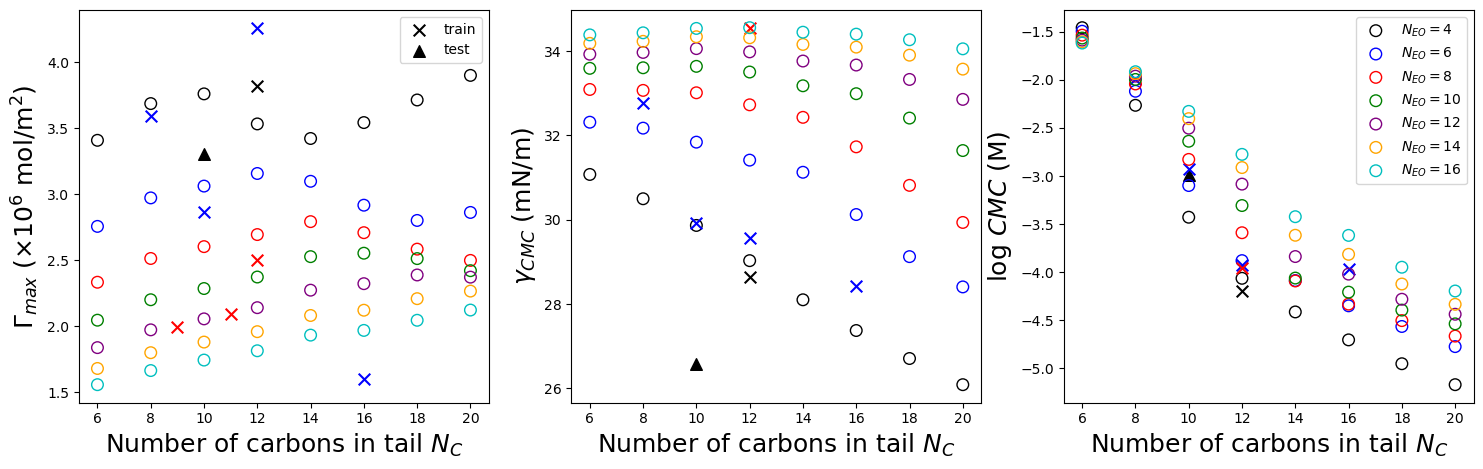

In [4]:
# PEO
import pandas as pd

# df2_PEO = pd.read_csv('061724_PEO_test_complete.csv')
# df2_PEO= pd.read_excel('062524_chemprop_addon_test.xlsx')
df2_PEO= pd.read_excel('072624_chemprop_gammacmc_test.xlsx')
df2_PEO
df_exp = pd.read_excel('071524_chemprop_gammacmc_realgammamaxpure.xlsx')
df_exp = df_exp[df_exp['headgroup']=='PEO'][df_exp['tailgroup']=='hydrocarbon']
df_exp_train = df_exp[np.isnan(df_exp['test'])]
df_exp_test = df_exp[df_exp['test']==True]

PEO_4 = df2_PEO[df2_PEO['N_EO']==4][df2_PEO['tailgroup']=='hydrocarbon']
PEO_6 = df2_PEO[df2_PEO['N_EO']==6][df2_PEO['tailgroup']=='hydrocarbon']
PEO_8= df2_PEO[df2_PEO['N_EO']==8][df2_PEO['tailgroup']=='hydrocarbon']
PEO_10 = df2_PEO[df2_PEO['N_EO']==10][df2_PEO['tailgroup']=='hydrocarbon']
PEO_12 = df2_PEO[df2_PEO['N_EO']==12][df2_PEO['tailgroup']=='hydrocarbon']
PEO_14 = df2_PEO[df2_PEO['N_EO']==14][df2_PEO['tailgroup']=='hydrocarbon']
PEO_16 = df2_PEO[df2_PEO['N_EO']==16][df2_PEO['tailgroup']=='hydrocarbon']
# df_exp = df2_PEO[df2_PEO['y_exp'].notna()]
N_EOs = [4,6,8,10,12,14,16]

color_code={
    4:'k',
    6:'b',
    8:'r',
    10:'g',
    12:'purple',
    14:'orange',
    16:'c'
}
map2df={
    4:PEO_4,
    6:PEO_6,
    8:PEO_8,
    10:PEO_10,
    12:PEO_12,
    14:PEO_14,
    16:PEO_16
}

fig, ax = plt.subplots(1,3,figsize=(18,5.1))
# Gamma_max
for N_EO in N_EOs:
    # exp 
    df_exp_train_tmp= df_exp_train[df_exp_train['N_EO']==N_EO]
    x = df_exp_train_tmp['N_C']
    y_pred = df_exp_train_tmp['SurfaceExcess (mol/m2)']
    ax[0].scatter(x,y_pred*1e6,color=color_code[N_EO], marker='x', s=70)

    df_exp_test_tmp= df_exp_test[df_exp_test['N_EO']==N_EO]
    x = df_exp_test_tmp['N_C']
    y_pred = df_exp_test_tmp['SurfaceExcess (mol/m2)']
    ax[0].scatter(x,y_pred*1e6,color=color_code[N_EO], marker='^', s=70)
    ax[0].legend(['train','test'])
    # pred
    df_tmp = map2df[N_EO]
    x = df_tmp['N_C']
    y_pred = df_tmp['pred_0']
    ax[0].scatter(x,y_pred*1e6,color=color_code[N_EO], facecolors='none', label = fr'$N_{{EO}}={N_EO}$', s=70)

    

# ax[0].legend(fontsize=10)
ax[0].set_xlabel(r'Number of carbons in tail $N_C$',fontsize=18)
ax[0].set_ylabel(r'$\Gamma_{max}$ ($\times$10$^6$ mol/m$^2$)',fontsize=18)

# gamma_cmc
for N_EO in N_EOs:
    df_tmp = map2df[N_EO]
    x = df_tmp['N_C']
    y_pred = df_tmp['pred_1']
    ax[1].scatter(x,y_pred,color=color_code[N_EO], facecolors='none', label = fr'$N_{{EO}}={N_EO}$', s=70)

    # exp 
    df_exp_train_tmp= df_exp_train[df_exp_train['N_EO']==N_EO]
    x = df_exp_train_tmp['N_C']
    y_pred = df_exp_train_tmp['Gamma_cmc (mN/m)']
    ax[1].scatter(x,y_pred,color=color_code[N_EO], marker='x', s=70)

    df_exp_test_tmp= df_exp_test[df_exp_test['N_EO']==N_EO]
    x = df_exp_test_tmp['N_C']
    y_pred = df_exp_test_tmp['Gamma_cmc (mN/m)']
    ax[1].scatter(x,y_pred,color=color_code[N_EO], marker='^', s=70)

# ax[1].legend(fontsize=8)
ax[1].set_xlabel(r'Number of carbons in tail $N_C$',fontsize=18)
ax[1].set_ylabel(r'$\gamma_{CMC}$ (mN/m)',fontsize=18)

# CMC
for N_EO in N_EOs:
    df_tmp = map2df[N_EO]
    x = df_tmp['N_C']
    y_pred = df_tmp['pred_2']
    ax[2].scatter(x,y_pred,color=color_code[N_EO], facecolors='none', label = fr'$N_{{EO}}={N_EO}$', s=70)

    # exp 
    df_exp_train_tmp= df_exp_train[df_exp_train['N_EO']==N_EO]
    x = df_exp_train_tmp['N_C']
    y_pred = df_exp_train_tmp['LogCMC (M)']
    ax[2].scatter(x,y_pred,color=color_code[N_EO], marker='x', s=70)

    df_exp_test_tmp= df_exp_test[df_exp_test['N_EO']==N_EO]
    x = df_exp_test_tmp['N_C']
    y_pred = df_exp_test_tmp['LogCMC (M)']
    ax[2].scatter(x,y_pred,color=color_code[N_EO], marker='^', s=70)

ax[2].legend(fontsize=10)
ax[2].set_xlabel(r'Number of carbons in tail $N_C$',fontsize=18)
ax[2].set_ylabel(r'log $CMC$ (M)',fontsize=18)


C:\Users\hsk81\AppData\Local\Temp\ipykernel_89356\963314293.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PEO_10_ml = df_ml[(df_ml['N_C']==10)][(df_ml['headgroup']=='PEO')]
C:\Users\hsk81\AppData\Local\Temp\ipykernel_89356\963314293.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PEO_12_ml = df_ml[(df_ml['N_C']==12)][(df_ml['headgroup']=='PEO')][(df_ml['tailgroup']=='hydrocarbon')]
C:\Users\hsk81\AppData\Local\Temp\ipykernel_89356\963314293.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PEO_12_ml = df_ml[(df_ml['N_C']==12)][(df_ml['headgroup']=='PEO')][(df_ml['tailgroup']=='hydrocarbon')]
C:\Users\hsk81\AppData\Local\Temp\ipykernel_89356\963314293.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  PEO_16_ml = df_ml[(df_ml['N_C']==16)][(df_ml['headgroup']=='PEO')]


(1.9, 4.0)

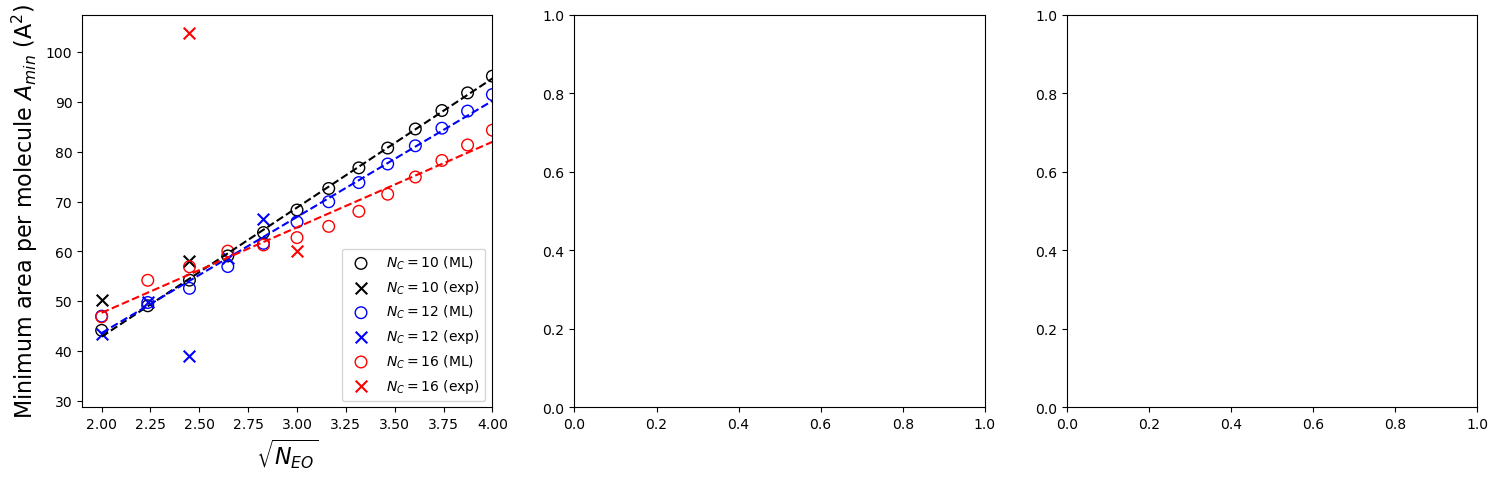

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(18,5.1))

df_ml = pd.read_excel('072624_chemprop_gammacmc_test.xlsx')
PEO_10_ml = df_ml[(df_ml['N_C']==10)][(df_ml['headgroup']=='PEO')]
PEO_12_ml = df_ml[(df_ml['N_C']==12)][(df_ml['headgroup']=='PEO')][(df_ml['tailgroup']=='hydrocarbon')]
PEO_16_ml = df_ml[(df_ml['N_C']==16)][(df_ml['headgroup']=='PEO')]

PEO_16 = df[(df['N_C']==16) & (df['headgroup']=='PEO')]
PEO_12 = df[(df['N_C']==12) & (df['headgroup']=='PEO') & (df['tailgroup']=='hydrocarbon')]
PEO_10 = df[(df['N_C']==10) & (df['headgroup']=='PEO')]

# fitting Am = a *sqrt(N_EO) + b
# PEO10
x = np.sqrt(PEO_10_ml['N_EO'])
y = PEO_10_ml['pred_Am']
ax[0].scatter(x,y,color='k', facecolors='none', label=r'$N_C=10$ (ML)',s=70)
coefficients = np.polyfit(x, y, 1) # fitting
polynomial = np.poly1d(coefficients)
ys = polynomial(x)
ax[0].plot(x, ys, color='k', linestyle='--')
# exp
x = np.sqrt(PEO_10['N_EO'])
y_pred = PEO_10['Am (A2)']
ax[0].scatter(x,y_pred,color='k',marker='x', label=r'$N_C=10$ (exp)',s=70)

# PEO12
x = np.sqrt(PEO_12_ml['N_EO'])
y = PEO_12_ml['pred_Am']
ax[0].scatter(x,y,color='b', facecolors='none', label=r'$N_C=12$ (ML)',s=70)
coefficients = np.polyfit(x, y, 1) # fitting
polynomial = np.poly1d(coefficients)
ys = polynomial(x)
ax[0].plot(x, ys, color='b', linestyle='--')
# exp
x = np.sqrt(PEO_12['N_EO'])
y_pred = PEO_12['Am (A2)']
# print(x,y_pred)
ax[0].scatter(x,y_pred,color='b',marker='x', label=r'$N_C=12$ (exp)',s=70)

# PEO16
x = np.sqrt(PEO_16_ml['N_EO'])
y = PEO_16_ml['pred_Am']
ax[0].scatter(x,y,color='r', facecolors='none', label=r'$N_C=16$ (ML)',s=70)
coefficients = np.polyfit(x, y, 1) # fitting
polynomial = np.poly1d(coefficients)
ys = polynomial(x)
ax[0].plot(x, ys, color='r', linestyle='--')
# exp
x = np.sqrt(PEO_16['N_EO'])
y_pred = PEO_16['Am (A2)']
ax[0].scatter(x,y_pred,color='r',marker='x', label=r'$N_C=16$ (exp)',s=70)
coefficients = np.polyfit(x, y_pred, 1) # fitting
polynomial = np.poly1d(coefficients)
ys = polynomial(x)
# plt.plot(x, ys, color='b')

ax[0].legend(fontsize=10)
ax[0].set_xlabel(r'$\sqrt{N_{EO}}$',fontsize=16)
ax[0].set_ylabel(r'Minimum area per molecule $A_{min}$ (A$^2$)',fontsize=16)
ax[0].set_xlim([1.9,4])


In [ ]:
# mapping
df3 = pd.read_excel('072624_chemprop_gammacmc_test.xlsx')
df_exp = pd.read_excel('071524_chemprop_gammacmc_realgammamaxpure.xlsx')
df_exp_train = df_exp[np.isnan(df_exp['test'])]
df_exp_test = df_exp[df_exp['test']==True]

df_alcohol = df3[df3['headgroup']=='alcohol']
df_sulfate = df3[df3['headgroup']=='sulfate']
df_sulfonate = df3[df3['headgroup']=='sulfonate']
df_TAB = df3[df3['headgroup']=='TAB']
df_carboxylacid = df3[df3['headgroup']=='carboxyl acid']
df_carboxylate = df3[df3['headgroup']=='carboxylate']
df_sulfatePEO = df3[df3['headgroup']=='sulfate-PEO']
df_sulfateTHP = df3[df3['headgroup']=='sulfate-THP']
df_trisPEO = df3[df3['headgroup']=='tris-PEO']
df_TABcarboxylate =df3[df3['headgroup']=='TAB-carboxylate']
df_glucoside =df3[df3['headgroup']=='glucoside']
df_maltoside =df3[df3['headgroup']=='maltoside']
df_glucamine =df3[df3['headgroup']=='glucamine']
df_pyridine =df3[df3['headgroup']=='pyridine']


color_code={
    'alcohol':'k',
    'sulfate':'k',
    'sulfonate':'b',
    'TAB':'g',
    'carboxyl acid':'purple',
    'carboxylate':'r',
    'sulfate-PEO':'g',
    'sulfate-THP':'g',
    'tris-PEO':'k',
    'TAB-carboxylate':'k',
    'glucoside':'b',
    'maltoside':'r',
    'glucamine':'g',
    'pyridine':'k'

}
map2df={
    'alcohol':df_alcohol,
    'sulfate':df_sulfate,
    'sulfonate':df_sulfonate,
    'TAB':df_TAB,
    'carboxyl acid':df_carboxylacid,
    'carboxylate':df_carboxylate,
    'sulfate-PEO':df_sulfatePEO,
    'sulfate-THP':df_sulfateTHP,
    'tris-PEO':df_trisPEO,
    'TAB-carboxylate':df_TABcarboxylate,
    'glucoside':df_glucoside,
    'maltoside':df_maltoside,
    'glucamine':df_glucamine,
    'pyridine':df_pyridine
}


(-5.5, 0.2)

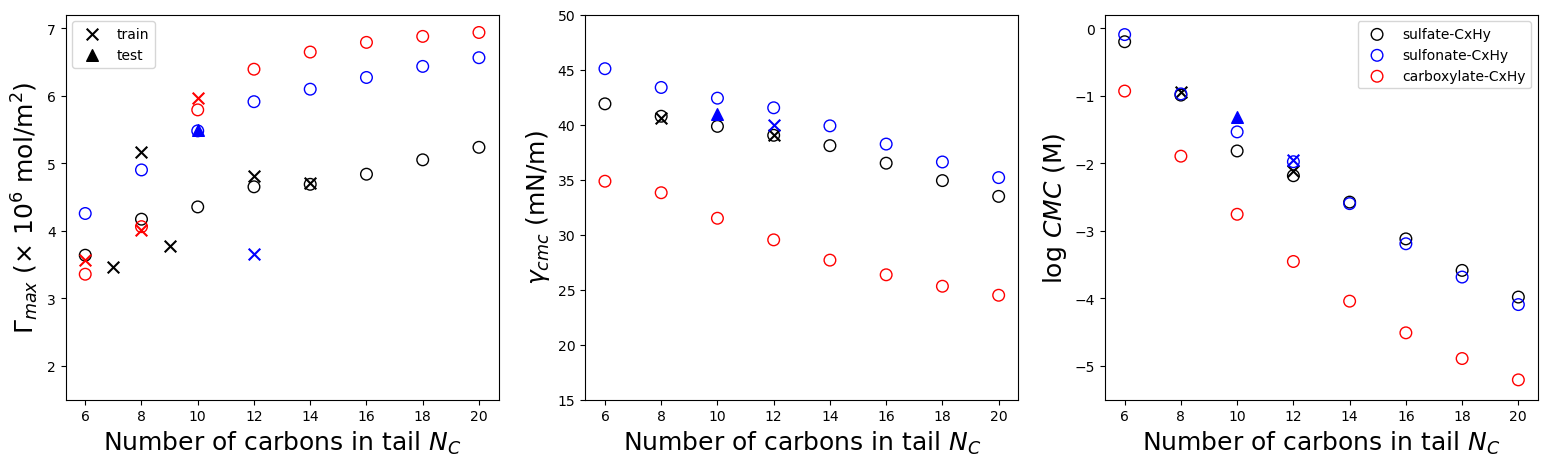

In [ ]:
################################ FIGURE ##########################

fig, ax = plt.subplots(1,3,figsize=(19,5))
headgroups = ['alcohol','carboxyl acid','tris-PEO','glucoside','maltoside','glucamine'] # all nonionic
headgroups = ['carboxyl acid','glucoside','maltoside','glucamine'] # some nonionic
headgroups = ['TAB'] # cationic
headgroups = ['sulfate','sulfonate','carboxylate'] # anionic
# headgroups = ['pyridine'] # zwitterionic
# Gamma_max
for headgroup in headgroups:
    df_tmp = map2df[headgroup]
    # exp 
    df_exp_train_tmp= df_exp_train[df_exp_train['headgroup']==headgroup]
    df_exp_train_tmp= df_exp_train_tmp[df_exp_train_tmp['branch']!=True]
    df_exp_train_tmp= df_exp_train_tmp[df_exp_train_tmp['tailgroup']=='hydrocarbon']
    x = df_exp_train_tmp['N_C']
    y_pred = df_exp_train_tmp['SurfaceExcess (mol/m2)']*10**6
    ax[0].scatter(x,y_pred,color=color_code[headgroup], marker='x',s=70)

    df_exp_test_tmp= df_exp_test[df_exp_test['headgroup']==headgroup]
    df_exp_test_tmp= df_exp_test_tmp[df_exp_test_tmp['branch']!=True]
    df_exp_test_tmp= df_exp_test_tmp[df_exp_test_tmp['tailgroup']=='hydrocarbon']
    x = df_exp_test_tmp['N_C']
    y_pred = df_exp_test_tmp['SurfaceExcess (mol/m2)']*10**6
    ax[0].scatter(x,y_pred,color=color_code[headgroup], marker='^',s=70)
    ax[0].legend(['train','test'])

    x = df_tmp['N_C'][df_tmp['tailgroup']=='hydrocarbon']
    y_pred = df_tmp['pred_0'][df_tmp['tailgroup']=='hydrocarbon']*10**6
    ax[0].scatter(x,y_pred,color=color_code[headgroup], facecolors='none',label=headgroup+'-CxFy',s=70)

ax[0].set_xlabel(r'Number of carbons in tail $N_C$',fontsize=18)
ax[0].set_ylabel(r'$\Gamma_{max}$ ($\times$ 10$^6$ mol/m$^2$)',fontsize=18)
ax[0].set_ylim([1.5, 7.2])

# K_L
for headgroup in headgroups:
    df_tmp = map2df[headgroup]

    x = df_tmp['N_C'][df_tmp['tailgroup']=='hydrocarbon']
    y_pred = df_tmp['pred_1'][df_tmp['tailgroup']=='hydrocarbon']
    ax[1].scatter(x,y_pred,color=color_code[headgroup], facecolors='none',label=headgroup+'-CxHy',s=70)
    
    # exp 
    df_exp_train_tmp= df_exp_train[df_exp_train['headgroup']==headgroup]
    df_exp_train_tmp= df_exp_train_tmp[df_exp_train_tmp['branch']!=True]
    df_exp_train_tmp= df_exp_train_tmp[df_exp_train_tmp['tailgroup']=='hydrocarbon']
    x = df_exp_train_tmp['N_C']
    y_pred = df_exp_train_tmp['Gamma_cmc (mN/m)']
    ax[1].scatter(x,y_pred,color=color_code[headgroup], marker='x',s=70)

    df_exp_test_tmp= df_exp_test[df_exp_test['headgroup']==headgroup]
    df_exp_test_tmp= df_exp_test_tmp[df_exp_test_tmp['branch']!=True]
    df_exp_test_tmp= df_exp_test_tmp[df_exp_test_tmp['tailgroup']=='hydrocarbon']
    x = df_exp_test_tmp['N_C']
    y_pred = df_exp_test_tmp['Gamma_cmc (mN/m)']
    ax[1].scatter(x,y_pred,color=color_code[headgroup], marker='^',s=70)
ax[1].set_xlabel(r'Number of carbons in tail $N_C$',fontsize=18)
ax[1].set_ylabel(r'$\gamma_{cmc}$ (mN/m)',fontsize=18)
ax[1].set_ylim([15, 50])

# CMC
for headgroup in headgroups:
    df_tmp = map2df[headgroup]

    x = df_tmp['N_C'][df_tmp['tailgroup']=='hydrocarbon']
    y_pred = df_tmp['pred_2'][df_tmp['tailgroup']=='hydrocarbon']
    ax[2].scatter(x,y_pred,color=color_code[headgroup], facecolors='none',label=headgroup+'-CxHy',s=70)

    # exp 
    df_exp_train_tmp= df_exp_train[df_exp_train['headgroup']==headgroup]
    df_exp_train_tmp= df_exp_train_tmp[df_exp_train_tmp['branch']!=True]
    df_exp_train_tmp= df_exp_train_tmp[df_exp_train_tmp['tailgroup']=='hydrocarbon']
    x = df_exp_train_tmp['N_C']
    y_pred = df_exp_train_tmp['LogCMC (M)']
    ax[2].scatter(x,y_pred,color=color_code[headgroup], marker='x',s=70)

    df_exp_test_tmp= df_exp_test[df_exp_test['headgroup']==headgroup]
    df_exp_test_tmp= df_exp_test_tmp[df_exp_test_tmp['branch']!=True]
    df_exp_test_tmp= df_exp_test_tmp[df_exp_test_tmp['tailgroup']=='hydrocarbon']
    x = df_exp_test_tmp['N_C']
    y_pred = df_exp_test_tmp['LogCMC (M)']
    ax[2].scatter(x,y_pred,color=color_code[headgroup], marker='^',s=70)

ax[2].set_xlabel(r'Number of carbons in tail $N_C$',fontsize=18)
ax[2].set_ylabel(r'log $CMC$ (M)',fontsize=18)

ax[2].legend()
ax[2].set_ylim([-5.5, 0.2])





(-5.5, 0.2)

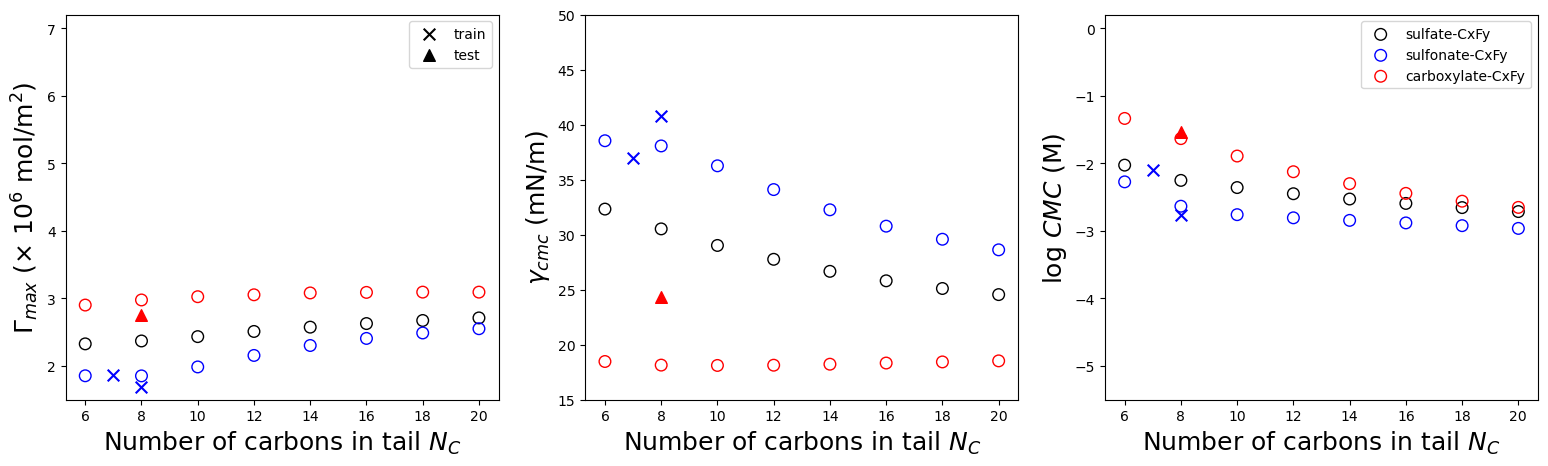

In [14]:
################################ FIGURE ##########################

fig, ax = plt.subplots(1,3,figsize=(19,5))
headgroups = ['alcohol','carboxyl acid','tris-PEO','glucoside','maltoside','glucamine'] # all nonionic
headgroups = ['carboxyl acid','glucoside','maltoside','glucamine'] # some nonionic
headgroups = ['TAB'] # cationic
headgroups = ['sulfate','sulfonate','carboxylate'] # anionic
# headgroups = ['pyridine'] # zwitterionic
# Gamma_max
for headgroup in headgroups:
    df_tmp = map2df[headgroup]
    # exp 
    df_exp_train_tmp= df_exp_train[df_exp_train['headgroup']==headgroup]
    df_exp_train_tmp= df_exp_train_tmp[df_exp_train_tmp['branch']!=True]
    df_exp_train_tmp= df_exp_train_tmp[df_exp_train_tmp['tailgroup']=='fluorocarbon']
    x = df_exp_train_tmp['N_C']
    y_pred = df_exp_train_tmp['SurfaceExcess (mol/m2)']*10**6
    ax[0].scatter(x,y_pred,color=color_code[headgroup], marker='x',s=70)

    df_exp_test_tmp= df_exp_test[df_exp_test['headgroup']==headgroup]
    df_exp_test_tmp= df_exp_test_tmp[df_exp_test_tmp['branch']!=True]
    df_exp_test_tmp= df_exp_test_tmp[df_exp_test_tmp['tailgroup']=='fluorocarbon']
    x = df_exp_test_tmp['N_C']
    y_pred = df_exp_test_tmp['SurfaceExcess (mol/m2)']*10**6
    ax[0].scatter(x,y_pred,color=color_code[headgroup], marker='^',s=70)
    ax[0].legend(['train','test'])

    x = df_tmp['N_C'][df_tmp['tailgroup']=='fluorocarbon']
    y_pred = df_tmp['pred_0'][df_tmp['tailgroup']=='fluorocarbon']*10**6
    ax[0].scatter(x,y_pred,color=color_code[headgroup], facecolors='none',label=headgroup+'-CxFy',s=70)

    # x = df_tmp['N_C'][df_tmp['tailgroup']=='trisiloxane']
    # y_pred = df_tmp['pred_0'][df_tmp['tailgroup']=='trisiloxane']
    # ax[0].scatter(x,y_pred,color=color_code[headgroup], facecolors='none', label=headgroup+'-TriSi',marker='s')

ax[0].set_xlabel(r'Number of carbons in tail $N_C$',fontsize=18)
ax[0].set_ylabel(r'$\Gamma_{max}$ ($\times$ 10$^6$ mol/m$^2$)',fontsize=18)
ax[0].set_ylim([1.5, 7.2])

# K_L
for headgroup in headgroups:
    df_tmp = map2df[headgroup]
    # x = df_tmp['N_C'][df_tmp['tailgroup']=='hydrocarbon']
    # y_pred = df_tmp['pred_1'][df_tmp['tailgroup']=='hydrocarbon']
    # ax[1].scatter(x,y_pred,color=color_code[headgroup], facecolors='none')

    x = df_tmp['N_C'][df_tmp['tailgroup']=='fluorocarbon']
    y_pred = df_tmp['pred_1'][df_tmp['tailgroup']=='fluorocarbon']
    ax[1].scatter(x,y_pred,color=color_code[headgroup], facecolors='none',label=headgroup+'-CxFy',s=70)

    # x = df_tmp['N_C'][df_tmp['tailgroup']=='trisiloxane']
    # y_pred = df_tmp['pred_1'][df_tmp['tailgroup']=='trisiloxane']
    # ax[1].scatter(x,y_pred,color=color_code[headgroup], facecolors='none', label=headgroup+'-TriSi',marker='s')
    
    # exp 
    df_exp_train_tmp= df_exp_train[df_exp_train['headgroup']==headgroup]
    df_exp_train_tmp= df_exp_train_tmp[df_exp_train_tmp['branch']!=True]
    df_exp_train_tmp= df_exp_train_tmp[df_exp_train_tmp['tailgroup']=='fluorocarbon']
    x = df_exp_train_tmp['N_C']
    y_pred = df_exp_train_tmp['Gamma_cmc (mN/m)']
    ax[1].scatter(x,y_pred,color=color_code[headgroup], marker='x',s=70)

    df_exp_test_tmp= df_exp_test[df_exp_test['headgroup']==headgroup]
    df_exp_test_tmp= df_exp_test_tmp[df_exp_test_tmp['branch']!=True]
    df_exp_test_tmp= df_exp_test_tmp[df_exp_test_tmp['tailgroup']=='fluorocarbon']
    x = df_exp_test_tmp['N_C']
    y_pred = df_exp_test_tmp['Gamma_cmc (mN/m)']
    ax[1].scatter(x,y_pred,color=color_code[headgroup], marker='^',s=70)
# ax[0].legend(fontsize=8)
ax[1].set_xlabel(r'Number of carbons in tail $N_C$',fontsize=18)
ax[1].set_ylabel(r'$\gamma_{cmc}$ (mN/m)',fontsize=18)
ax[1].set_ylim([15, 50])

# CMC
for headgroup in headgroups:
    df_tmp = map2df[headgroup]
    # x = df_tmp['N_C'][df_tmp['tailgroup']=='hydrocarbon']
    # y_pred = df_tmp['pred_2'][df_tmp['tailgroup']=='hydrocarbon']
    # ax[2].scatter(x,y_pred,color=color_code[headgroup], facecolors='none')

    x = df_tmp['N_C'][df_tmp['tailgroup']=='fluorocarbon']
    y_pred = df_tmp['pred_2'][df_tmp['tailgroup']=='fluorocarbon']
    ax[2].scatter(x,y_pred,color=color_code[headgroup], facecolors='none',label=headgroup+'-CxFy',s=70)

    # x = df_tmp['N_C'][df_tmp['tailgroup']=='trisiloxane']
    # y_pred = df_tmp['pred_2'][df_tmp['tailgroup']=='trisiloxane']
    # ax[2].scatter(x,y_pred,color=color_code[headgroup], facecolors='none', label=headgroup+'-TriSi',marker='s')

    # exp 
    df_exp_train_tmp= df_exp_train[df_exp_train['headgroup']==headgroup]
    df_exp_train_tmp= df_exp_train_tmp[df_exp_train_tmp['branch']!=True]
    df_exp_train_tmp= df_exp_train_tmp[df_exp_train_tmp['tailgroup']=='fluorocarbon']
    x = df_exp_train_tmp['N_C']
    y_pred = df_exp_train_tmp['LogCMC (M)']
    ax[2].scatter(x,y_pred,color=color_code[headgroup], marker='x',s=70)

    df_exp_test_tmp= df_exp_test[df_exp_test['headgroup']==headgroup]
    df_exp_test_tmp= df_exp_test_tmp[df_exp_test_tmp['branch']!=True]
    df_exp_test_tmp= df_exp_test_tmp[df_exp_test_tmp['tailgroup']=='fluorocarbon']
    x = df_exp_test_tmp['N_C']
    y_pred = df_exp_test_tmp['LogCMC (M)']
    ax[2].scatter(x,y_pred,color=color_code[headgroup], marker='^',s=70)

ax[2].set_xlabel(r'Number of carbons in tail $N_C$',fontsize=18)
ax[2].set_ylabel(r'log $CMC$ (M)',fontsize=18)

ax[2].legend()
ax[2].set_ylim([-5.5, 0.2])





Text(0, 0.5, 'Log $CMC$ (M)')

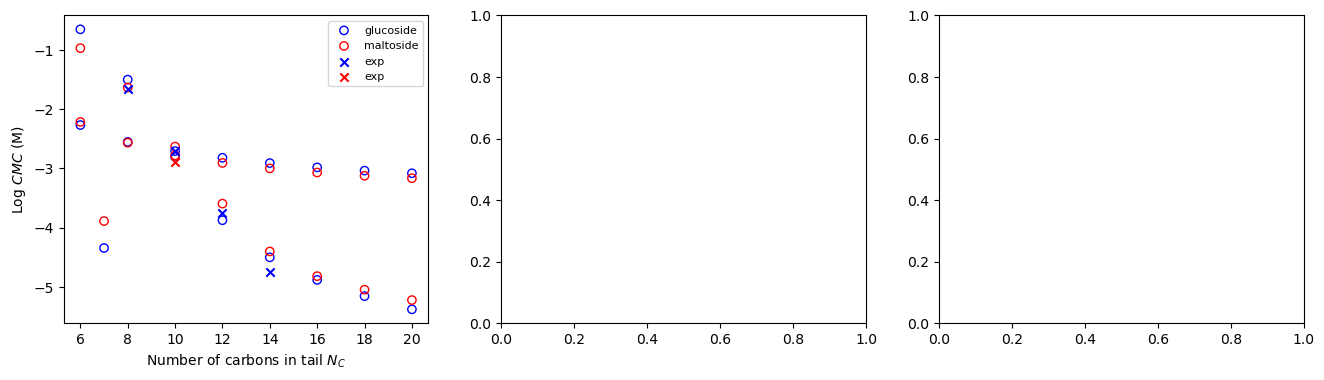

In [18]:
# Varga2012_GluMal
# 10. lnCMC and Nc are linear 

fig, ax = plt.subplots(1,3,figsize=(16,4))
headgroups = ['glucoside','maltoside']
# Gamma_max
for headgroup in headgroups:
    df_tmp = map2df[headgroup]
    x = df_tmp['N_C']
    y_pred = df_tmp['pred_2']
    ax[0].scatter(x,y_pred,color=color_code[headgroup], facecolors='none',label=headgroup)
    
# exp
x_exp = [8,10,12,14]
y_exp = [-3.805309735,-6.221238938,-8.637168142,-10.94690265]
y_exp = [y / 2.303 for y in y_exp]
ax[0].scatter(x_exp,y_exp,color='b',marker='x',label='exp')

x_exp = [10]
y_exp = [-6.672566372/2.303]
ax[0].scatter(x_exp,y_exp,color='r',marker='x',label='exp')

ax[0].legend(fontsize=8)
ax[0].set_xlabel(r'Number of carbons in tail $N_C$')
ax[0].set_ylabel(r'Log $CMC$ (M)')

Text(0, 0.5, 'Log $CMC$ (M)')

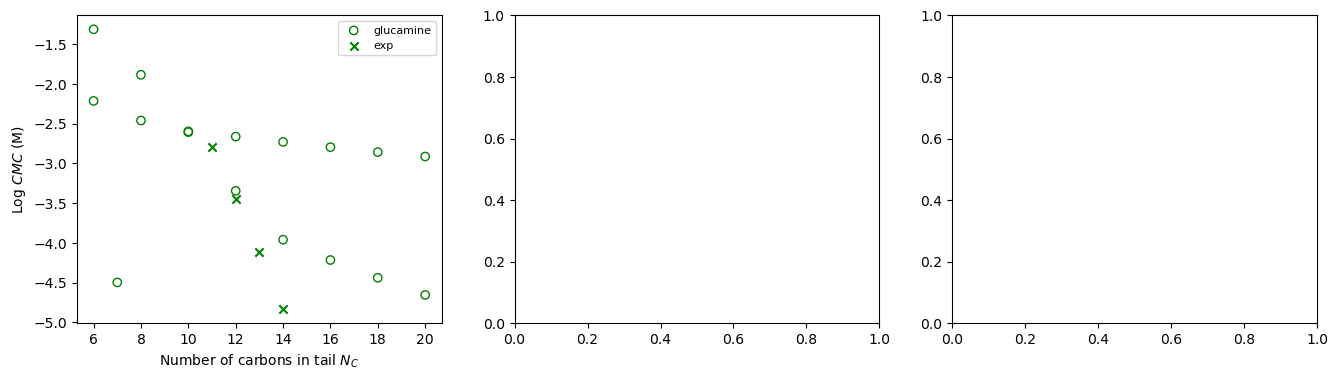

In [19]:
# Zhu1999_Glucamine
# 11. lnCMC and Nc are linear

fig, ax = plt.subplots(1,3,figsize=(16,4))
headgroups = ['glucamine']
# Gamma_max
for headgroup in headgroups:
    df_tmp = map2df[headgroup]
    x = df_tmp['N_C']
    y_pred = df_tmp['pred_2']
    ax[0].scatter(x,y_pred,color=color_code[headgroup], facecolors='none',label=headgroup)
    
# exp
x_exp = [11,12,13,14]
y_exp = [-2.796747408,-3.448346555,-4.116748997,-4.836610205]
ax[0].scatter(x_exp,y_exp,color='g',marker='x',label='exp')



ax[0].legend(fontsize=8)
ax[0].set_xlabel(r'Number of carbons in tail $N_C$')
ax[0].set_ylabel(r'Log $CMC$ (M)')

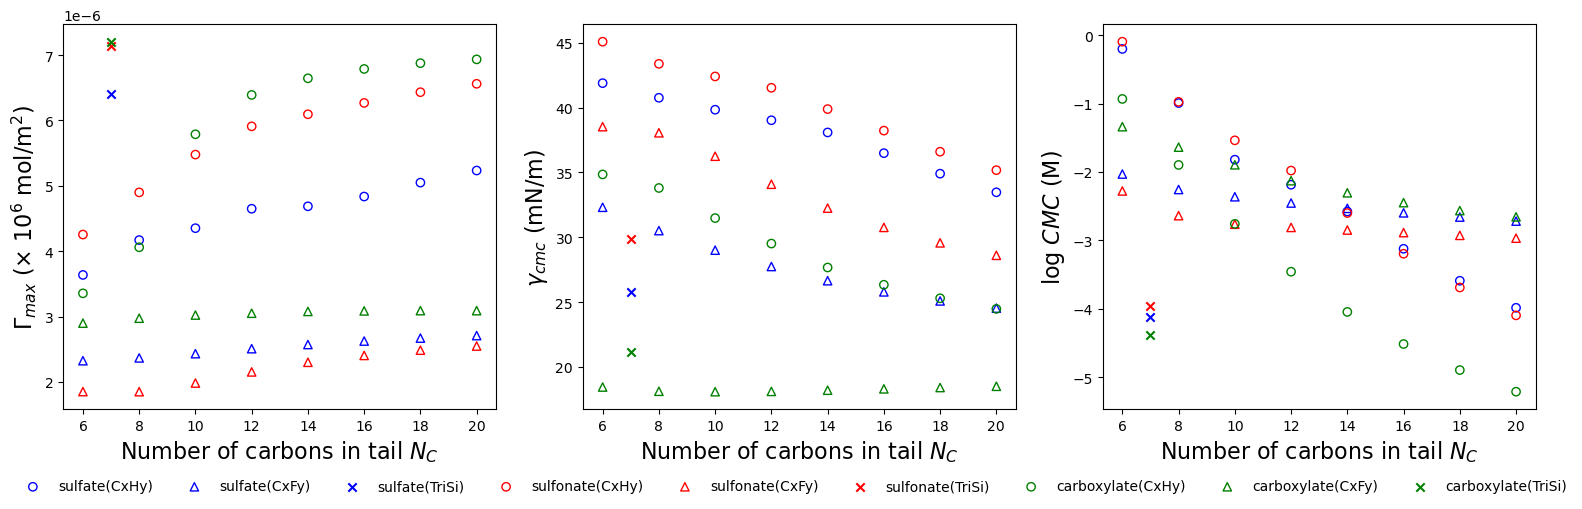

In [10]:
################################ FIGURE ##########################

fig, ax = plt.subplots(1,3,figsize=(19,5))
headgroups = ['alcohol','carboxyl acid','tris-PEO','glucoside','maltoside','glucamine'] # all nonionic
headgroups = ['carboxyl acid','glucoside','maltoside','glucamine'] # some nonionic
headgroups = ['TAB'] # cationic
headgroups = ['sulfate','sulfonate','carboxylate'] # anionic
# headgroups = ['pyridine'] # zwitterionic
# Gamma_max
for headgroup in headgroups:
    df_tmp = map2df[headgroup]
    x = df_tmp['N_C'][df_tmp['tailgroup']=='hydrocarbon']
    y_pred = df_tmp['pred_0'][df_tmp['tailgroup']=='hydrocarbon']
    ax[0].scatter(x,y_pred,color=color_code[headgroup], facecolors='none',label=headgroup+'(CxHy)')

    x = df_tmp['N_C'][df_tmp['tailgroup']=='fluorocarbon']
    y_pred = df_tmp['pred_0'][df_tmp['tailgroup']=='fluorocarbon']
    ax[0].scatter(x,y_pred,color=color_code[headgroup], facecolors='none',label=headgroup+'(CxFy)',marker='^')

    x = df_tmp['N_C'][df_tmp['tailgroup']=='trisiloxane']
    y_pred = df_tmp['pred_0'][df_tmp['tailgroup']=='trisiloxane']
    ax[0].scatter(x,y_pred,color=color_code[headgroup], label=headgroup+'(TriSi)',marker='x')

ax[0].set_xlabel(r'Number of carbons in tail $N_C$',fontsize=16)
ax[0].set_ylabel(r'$\Gamma_{max}$ ($\times$ 10$^6$ mol/m$^2$)',fontsize=16)

# K_L
for headgroup in headgroups:
    df_tmp = map2df[headgroup]
    x = df_tmp['N_C'][df_tmp['tailgroup']=='hydrocarbon']
    y_pred = df_tmp['pred_1'][df_tmp['tailgroup']=='hydrocarbon']
    ax[1].scatter(x,y_pred,color=color_code[headgroup], facecolors='none')

    x = df_tmp['N_C'][df_tmp['tailgroup']=='fluorocarbon']
    y_pred = df_tmp['pred_1'][df_tmp['tailgroup']=='fluorocarbon']
    ax[1].scatter(x,y_pred,color=color_code[headgroup], facecolors='none',label=headgroup+'(CxFy)',marker='^')

    x = df_tmp['N_C'][df_tmp['tailgroup']=='trisiloxane']
    y_pred = df_tmp['pred_1'][df_tmp['tailgroup']=='trisiloxane']
    ax[1].scatter(x,y_pred,color=color_code[headgroup], label=headgroup+'(TriSi)',marker='x')
    
# ax[0].legend(fontsize=8)
ax[1].set_xlabel(r'Number of carbons in tail $N_C$',fontsize=16)
ax[1].set_ylabel(r'$\gamma_{cmc}$ (mN/m)',fontsize=16)

# CMC
for headgroup in headgroups:
    df_tmp = map2df[headgroup]
    x = df_tmp['N_C'][df_tmp['tailgroup']=='hydrocarbon']
    y_pred = df_tmp['pred_2'][df_tmp['tailgroup']=='hydrocarbon']
    ax[2].scatter(x,y_pred,color=color_code[headgroup], facecolors='none')

    x = df_tmp['N_C'][df_tmp['tailgroup']=='fluorocarbon']
    y_pred = df_tmp['pred_2'][df_tmp['tailgroup']=='fluorocarbon']
    ax[2].scatter(x,y_pred,color=color_code[headgroup], facecolors='none',label=headgroup+'(CxFy)',marker='^')

    x = df_tmp['N_C'][df_tmp['tailgroup']=='trisiloxane']
    y_pred = df_tmp['pred_2'][df_tmp['tailgroup']=='trisiloxane']
    ax[2].scatter(x,y_pred,color=color_code[headgroup], label=headgroup+'(TriSi)',marker='x')

ax[2].set_xlabel(r'Number of carbons in tail $N_C$',fontsize=16)
ax[2].set_ylabel(r'log $CMC$ (M)',fontsize=16)

ax[0].legend(bbox_to_anchor=(3.5, -0.15), fancybox=False, ncol=9,fontsize=10,edgecolor='white')



